# Cluster Analysis

In [6]:
import pandas as pd 
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from scipy.stats import f_oneway, kruskal

Run this line to import utils:

In [7]:
%run ../../utils/utils.py

## 1. Load Data

In [8]:
df = pd.read_csv('../../data/featured_data.csv')
df.head()

,s1_edad,s1_genero,s1_experiencia_clinica,s1_educacion,s1_titulo_terciario,s1_titulo,s1_no_titulo_universitario,s1_horas_semana_pacientes_atendidos,s1_contexto_trabajo,s1_orientacion_teo,...,s4_no_tiempo_aprender_tbe,s4_capacitacion_tbe_demasiado_dinero,s4_no_saber_tbe,s4_entrenamiento_clinico_no_info_tbe,s4_alianza_terapeutica_mas_importante,s4_terapias_igualmente_efectivas,s4_empleador_no_fondos_capacitacion_tbe,s4_exp_clinica_mas_importante_que_evidencia_cientifica,provincia_residencia,consentimiento_informado
0,41.0,Femenino,1.2,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,12.0,Ámbito Privado,Ecléctico (más de una de estas opciones),...,4.0,4.0,7.0,0.0,6.0,4.0,6.0,2.0,Provincia de Buenos Aires,NaN
1,26.0,Femenino,0.2,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,13.0,"Ámbito Privado, Obra Social o Prepaga",Terapias Cognitivas/Comportamentales,...,1.0,6.0,1.0,0.0,4.0,2.0,7.0,3.0,Provincia de Buenos Aires,NaN
2,27.0,Femenino,1.0,Carrera de Especialización,NaN,Lic. en Psicología,NaN,30.0,"Ámbito Privado, Obra Social o Prepaga",Terapias Cognitivas/Comportamentales,...,1.0,4.0,1.0,1.0,1.0,1.0,0.0,4.0,Ciudad Autónoma de Buenos Aires (CABA),NaN
3,30.0,Masculino,1.3,Carrera de Especialización,NaN,Lic. en Psicología,NaN,35.0,Ámbito Privado,Terapias Cognitivas/Comportamentales,...,2.0,3.0,0.0,4.0,3.0,0.0,7.0,3.0,Provincia de Buenos Aires,NaN
4,26.0,Masculino,2.0,Licenciatura de Grado,NaN,Lic. en Psicología,NaN,46.0,Ámbito Público (hospital u otro),Terapias Cognitivas/Comportamentales,...,4.0,6.0,1.0,4.0,4.0,1.0,7.0,4.0,Provincia de Buenos Aires,NaN


In [9]:
df_subset_s2 = create_section_2(df)
variables_s2 = ['s2_evidencia_cientifica', 's2_experiencia_personal', 's2_entrenamiento_clinica',
             's2_tratamiento_preferencia_consultantes', 's2_intuicion', 's2_terapia_personal']

df_subset_s3 = create_section_3(df) 
variables_s3 = ['s3_tratamiento_personal_consultantes', 's3_investigacion_empirica_ensayos_controlados',
             's3_supervision', 's3_estudios_de_caso', 's3_discusion_pares', 's3_libros', 
             's3_observaciones_casos_clinicos', 's3_medidas_resultado', 's3_guias_manuales_clinicos']

df_subset_s4 = create_section_4(df)

# List of variables for which you want to create point plots
variables_s4 = ['s4_apertura_terapias_desarrolladas_por_investigadores', 's4_nueva_terapia_intento',
             's4_terapia_manualizada', 's4_diagnosticos_utilizados_son_simples', 
             's4_tratamientos_preferencia_no_probados_ensayo_controlado', 's4_enfoque_tratamiento_individual', 
             's4_alianza_terapeutica_mas_importante', 's4_terapias_igualmente_efectivas', 
             's4_exp_clinica_mas_importante_que_evidencia_cientifica', 's4_actualizacion_info_cientifica', 
             's4_formacion_enfasis_investigacion', 's4_supervisores_terapia_evidencia_requerimiento', 
             's4_atraer_consultantes_con_tbe', 's4_hallazgos_cientificos_practica_diaria', 
             's4_interes_aprender_tbe', 's4_tratamientos_utilizados_base_empirica', 
             's4_complejidad_consultantes_ensayos_clinicos', 's4_consultantes_prefieren_otros_tratamientos', 
             's4_no_tiempo_aprender_tbe', 's4_capacitacion_tbe_demasiado_dinero', 
             's4_no_saber_tbe', 's4_entrenamiento_clinico_no_info_tbe', 
             's4_empleador_no_fondos_capacitacion_tbe'] 

## 2. Cluster Analysis

### 2.1 Combine Data From All Sections

In [10]:
# Combine data from all sections
all_sections = pd.concat([df_subset_s2[variables_s2], 
                          df_subset_s3[variables_s3], 
                          df_subset_s4[variables_s4]], axis=1)

# Add demographic variables for chi-square tests (optional)
demographic_vars = ['s1_orientacion_teo', 's1_edad', 's1_genero', 's1_horas_semana_pacientes_atendidos']
all_data = pd.concat([all_sections, df_subset_s2[demographic_vars]], axis=1)

# Clean data (drop rows with missing values)
all_data_clean = all_data.dropna()

# Separate features and target variable (optional for chi-square tests)
features = all_data_clean.drop(columns=demographic_vars)
target = all_data_clean['s1_orientacion_teo']

### 2.2 Run a PCA And Determine Number Of Components And Clusters

To determine the optical number of clusters, we used the elbow curve, knee detector, and the silhoutte scores for verification

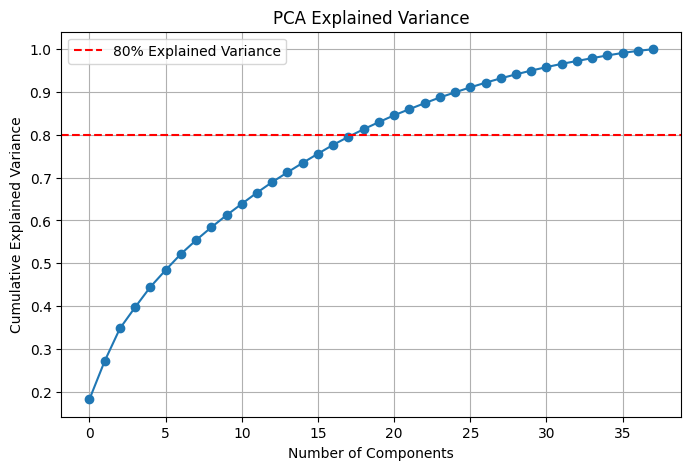

Number of components to retain: 19


Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\casasa9j\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 992, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.1008.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1612, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "C:\Program Files\Win

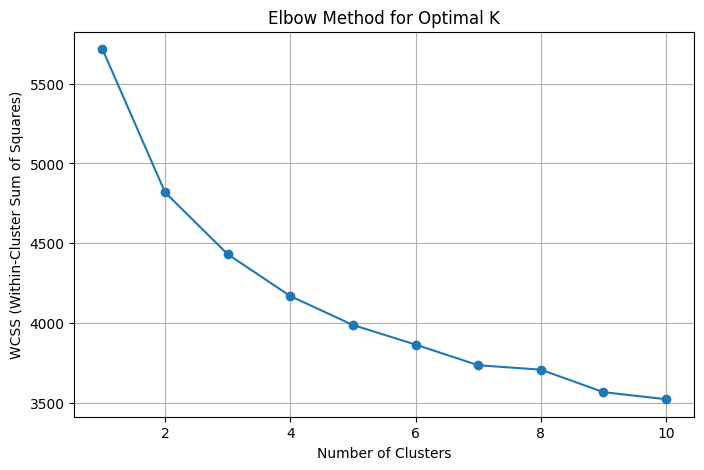

Optimal number of clusters: 4
For k=2, the silhouette score is 0.2148
For k=3, the silhouette score is 0.0994
For k=4, the silhouette score is 0.0809
For k=5, the silhouette score is 0.0867
For k=6, the silhouette score is 0.0804
For k=7, the silhouette score is 0.0698
For k=8, the silhouette score is 0.0511
For k=9, the silhouette score is 0.0671
For k=10, the silhouette score is 0.0569


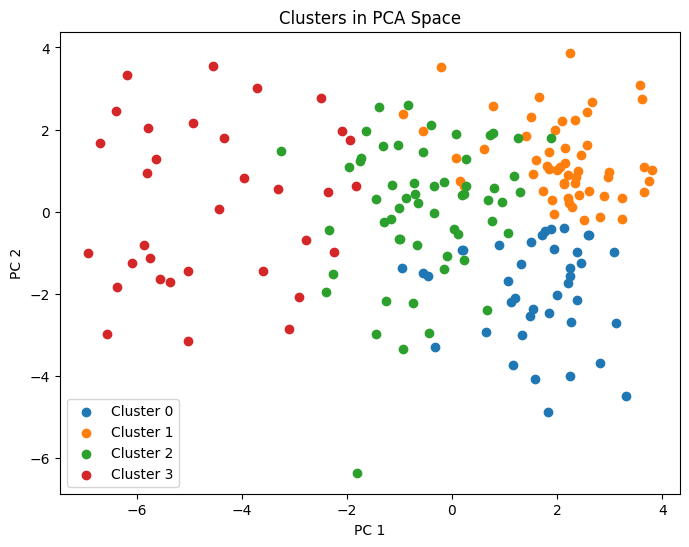

In [11]:
# Fix all sources of randomness
random.seed(42)
np.random.seed(42)

# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.astype(np.float32))  

# PCA with fixed random state
pca = PCA(random_state=42, svd_solver="full") 
pca_data = pca.fit_transform(features_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Determine optimal number of components (e.g., 80% variance)
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to retain: {n_components}")

# Re-run PCA with the chosen number of components
pca = PCA(n_components=n_components, random_state=42, svd_solver="full")
pca_reduced_data = pca.fit_transform(features_scaled)

# K-Means: Determine optimal clusters using Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, algorithm="lloyd")  # Ensure stability
    kmeans.fit(pca_reduced_data)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

# Identify optimal number of clusters using KneeLocator
optimal_k = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing").knee
print(f"Optimal number of clusters: {optimal_k}")

# Compute silhouette scores for verification
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is invalid for k=1
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, algorithm="lloyd")
    labels = kmeans.fit_predict(pca_reduced_data)
    silhouette_avg = silhouette_score(pca_reduced_data, labels)
    silhouette_scores.append((k, silhouette_avg))
    print(f"For k={k}, the silhouette score is {silhouette_avg:.4f}")

# Fit K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42, algorithm="lloyd")
cluster_labels = kmeans.fit_predict(pca_reduced_data)

# Add cluster labels to the data
all_data_clean = all_data_clean.copy()  # Ensure we don't modify the original DataFrame
all_data_clean['Cluster'] = cluster_labels

# Visualize clusters in 2D PCA space
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(pca_reduced_data[cluster_labels == cluster, 0], 
                pca_reduced_data[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster}')
plt.title('Clusters in PCA Space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()


### 2.3 Chi-Square Test

In [12]:
# Chi-Square Test
cross_tab = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("\n--- Chi-Square Test ---")
print(f"Chi²: {chi2:.2f}, p: {p:.4e}, DOF: {dof}")
print(cross_tab)

# PCA Loadings
loadings = pd.DataFrame(pca.components_.T, index=features.columns, 
                        columns=[f'PC{i+1}' for i in range(n_components)])
print("\n--- PCA Loadings ---")
print(loadings)


--- Chi-Square Test ---
Chi²: 70.30, p: 1.3306e-11, DOF: 9
s1_orientacion_teo  Ecléctico (más de una de estas opciones)  Psicoanálisis  \
Cluster                                                                       
0                                                          4              0   
1                                                          6              8   
2                                                         10             22   
3                                                          4             25   

s1_orientacion_teo  Sistémica  Terapias Cognitivas/Comportamentales  
Cluster                                                              
0                           2                                    34  
1                           6                                    35  
2                           5                                    20  
3                           1                                     3  

--- PCA Loadings ---
                       

### 2.4 Estimate Size Effect

In [13]:
n = cross_tab.values.sum()  # Total number of observations
r, k = cross_tab.shape      # Rows and columns of the table
cramers_v = np.sqrt(chi2 / (n * (min(r-1, k-1))))
print(f"Cramér's V: {cramers_v:.2f}")

Cramér's V: 0.36


### 2.5 Loadings for PCA

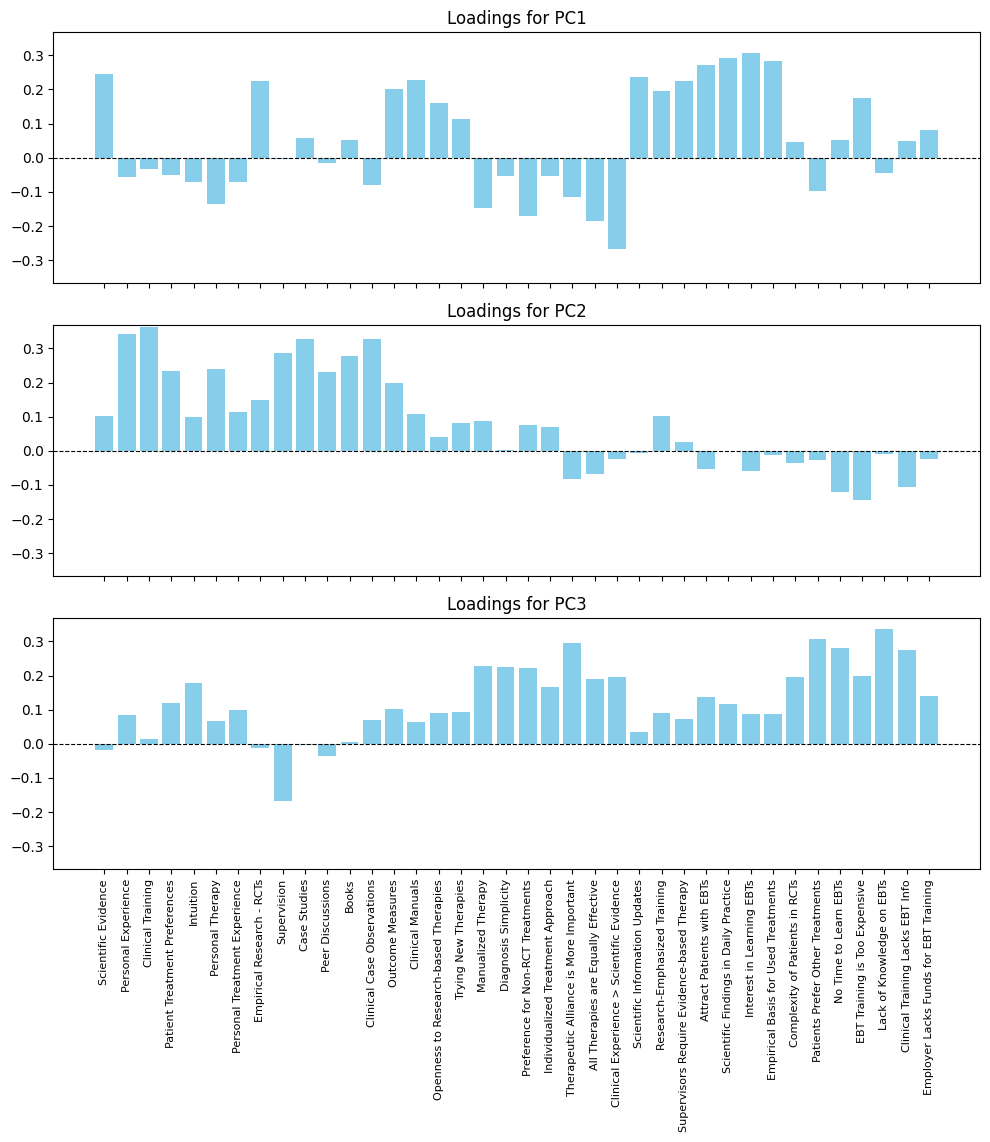

In [14]:
# Assuming 'pca' and 'features' are already defined
# Loadings for the first 5 principal components
loadings = pd.DataFrame(pca.components_[0:3, :], columns=features.columns)

# Translation dictionary
translation_dict = { 
    "s1_edad": "Age",
    "s1_genero": "Gender",
    "s1_experiencia_clinica": "Clinical Experience",
    "s1_educacion": "Education",
    "s1_titulo_terciario": "Tertiary Degree",
    "s1_titulo": "Degree",
    "s1_no_titulo_universitario": "No University Degree",
    "s1_horas_semana_pacientes_atendidos": "Hours per Week - Patients Attended",
    "s1_contexto_trabajo": "Work Context",
    "s1_orientacion_teo": "Theoretical Orientation",
    "s1_marco_teo_terapia_basada_arte": "Theoretical Framework - Art Therapy",
    "s1_marco_teo_psa": "Theoretical Framework - Psychoanalysis",
    "s1_marco_teo_tcc": "Theoretical Framework - CBT",
    "s1_marco_teo_humanista": "Theoretical Framework - Humanistic",
    "s1_marco_teo_eclectico": "Theoretical Framework - Eclectic",
    "s2_evidencia_cientifica": "Scientific Evidence",
    "s2_experiencia_personal": "Personal Experience",
    "s2_entrenamiento_clinica": "Clinical Training",
    "s2_tratamiento_preferencia_consultantes": "Patient Treatment Preferences",
    "s2_intuicion": "Intuition",
    "s2_terapia_personal": "Personal Therapy",
    "s3_tratamiento_personal_consultantes": "Personal Treatment Experience",
    "s3_investigacion_empirica_ensayos_controlados": "Empirical Research - RCTs",
    "s3_supervision": "Supervision",
    "s3_estudios_de_caso": "Case Studies",
    "s3_discusion_pares": "Peer Discussions",
    "s3_libros": "Books",
    "s3_observaciones_casos_clinicos": "Clinical Case Observations",
    "s3_medidas_resultado": "Outcome Measures",
    "s3_guias_manuales_clinicos": "Clinical Manuals",
    "s4_apertura_terapias_desarrolladas_por_investigadores": "Openness to Research-based Therapies",
    "s4_actualizacion_info_cientifica": "Scientific Information Updates",
    "s4_formacion_enfasis_investigacion": "Research-Emphasized Training",
    "s4_supervisores_terapia_evidencia_requerimiento": "Supervisors Require Evidence-based Therapy",
    "s4_tratamientos_cientificos_eficientes": "Efficient Scientific Treatments",
    "s4_atraer_consultantes_con_tbe": "Attract Patients with EBTs",
    "s4_hallazgos_cientificos_practica_diaria": "Scientific Findings in Daily Practice",
    "s4_nueva_terapia_intento": "Trying New Therapies",
    "s4_interes_aprender_tbe": "Interest in Learning EBTs",
    "s4_tratamientos_utilizados_base_empirica": "Empirical Basis for Used Treatments",
    "s4_complejidad_consultantes_ensayos_clinicos": "Complexity of Patients in RCTs",
    "s4_consultantes_prefieren_otros_tratamientos": "Patients Prefer Other Treatments",
    "s4_terapia_manualizada": "Manualized Therapy",
    "s4_diagnosticos_utilizados_son_simples": "Diagnosis Simplicity",
    "s4_tratamientos_preferencia_no_probados_ensayo_controlado": "Preference for Non-RCT Treatments",
    "s4_enfoque_tratamiento_individual": "Individualized Treatment Approach",
    "s4_no_tiempo_aprender_tbe": "No Time to Learn EBTs",
    "s4_capacitacion_tbe_demasiado_dinero": "EBT Training is Too Expensive",
    "s4_no_saber_tbe": "Lack of Knowledge on EBTs",
    "s4_entrenamiento_clinico_no_info_tbe": "Clinical Training Lacks EBT Info",
    "s4_alianza_terapeutica_mas_importante": "Therapeutic Alliance is More Important",
    "s4_terapias_igualmente_efectivas": "All Therapies are Equally Effective",
    "s4_empleador_no_fondos_capacitacion_tbe": "Employer Lacks Funds for EBT Training",
    "s4_exp_clinica_mas_importante_que_evidencia_cientifica": "Clinical Experience > Scientific Evidence",
    "provincia_residencia": "Residence Province",
    "consentimiento_informado": "Informed Consent"
}

# Rename columns
loadings.rename(columns=translation_dict, inplace=True)

# Maximum value for scaling purposes
maxPC = 1.01 * np.max(np.abs(loadings.values))

# Create subplots for each of the first 5 components
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.iloc[i, :]
    ax.bar(pc_loadings.index, pc_loadings.values, color='skyblue')
    ax.set_ylim(-maxPC, maxPC)
    ax.set_title(f"Loadings for PC{i+1}", fontsize=12)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.tick_params(axis='x', rotation=90, labelsize=8)

fig.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()


## 3. Calculate Standard Deviation And Select Top Variables For Radar Plot

To visualize the difference of the variables across the clusters, we 1) added the cluster labels to the original variables, 2) calculate the standard deviation across clusters for each variable, 3) selected the top 5 variables with the highest variation, and 4) display a radar plot

In [15]:
# Add cluster labels to the original features
cluster_data = features.copy()
cluster_data['Cluster'] = cluster_labels

# Compute mean values of variables for each cluster
cluster_means = cluster_data.groupby('Cluster').mean()

# Display cluster profiles
print("\nCluster Profiles (Variable Means):")
cluster_means

# Optional: Visualize profiles using radar plots or heatmaps


Cluster Profiles (Variable Means):


,s2_evidencia_cientifica,s2_experiencia_personal,s2_entrenamiento_clinica,s2_tratamiento_preferencia_consultantes,s2_intuicion,s2_terapia_personal,s3_tratamiento_personal_consultantes,s3_investigacion_empirica_ensayos_controlados,s3_supervision,s3_estudios_de_caso,...,s4_hallazgos_cientificos_practica_diaria,s4_interes_aprender_tbe,s4_tratamientos_utilizados_base_empirica,s4_complejidad_consultantes_ensayos_clinicos,s4_consultantes_prefieren_otros_tratamientos,s4_no_tiempo_aprender_tbe,s4_capacitacion_tbe_demasiado_dinero,s4_no_saber_tbe,s4_entrenamiento_clinico_no_info_tbe,s4_empleador_no_fondos_capacitacion_tbe
Cluster,,,,,,,,,,,,,,,,,,,,,
0,6.500000,3.725000,4.050000,1.950000,2.175000,2.975000,5.075000,3.875000,4.750000,3.150000,...,6.300000,6.450000,6.400000,5.275000,2.575000,2.000000,4.300000,1.200000,3.550000,2.075000
1,6.345455,6.127273,6.218182,4.000000,3.400000,4.890909,5.636364,5.218182,6.290909,5.090909,...,6.818182,6.800000,6.636364,4.818182,2.490909,1.418182,4.072727,1.236364,2.745455,2.581818
2,5.157895,5.754386,5.543860,4.210526,3.824561,5.508772,5.578947,3.614035,5.140351,4.333333,...,5.719298,5.491228,5.140351,5.175439,4.649123,2.754386,4.385965,2.964912,4.035088,3.192982
3,3.666667,5.878788,5.848485,3.666667,3.545455,6.030303,6.121212,1.939394,5.969697,3.727273,...,1.969697,1.666667,1.818182,4.393939,3.484848,0.787879,1.424242,1.666667,2.090909,1.121212


In [16]:
# Calculate standard deviation across clusters for each variable
std_across_clusters = cluster_means.std(axis=0)

# Sort by importance (higher std means greater difference across clusters)
sorted_variables = std_across_clusters.sort_values(ascending=False)
print("Variables with highest variation across clusters:")
print(sorted_variables.head(10))

Variables with highest variation across clusters:
s4_interes_aprender_tbe                                   2.356079
s4_atraer_consultantes_con_tbe                            2.311286
s4_tratamientos_utilizados_base_empirica                  2.219711
s4_hallazgos_cientificos_practica_diaria                  2.200987
s4_actualizacion_info_cientifica                          2.180217
s4_supervisores_terapia_evidencia_requerimiento           1.976189
s4_formacion_enfasis_investigacion                        1.524165
s4_exp_clinica_mas_importante_que_evidencia_cientifica    1.497151
s4_capacitacion_tbe_demasiado_dinero                      1.420487
s3_investigacion_empirica_ensayos_controlados             1.346197
dtype: float64


### 3.1 Radar Plot

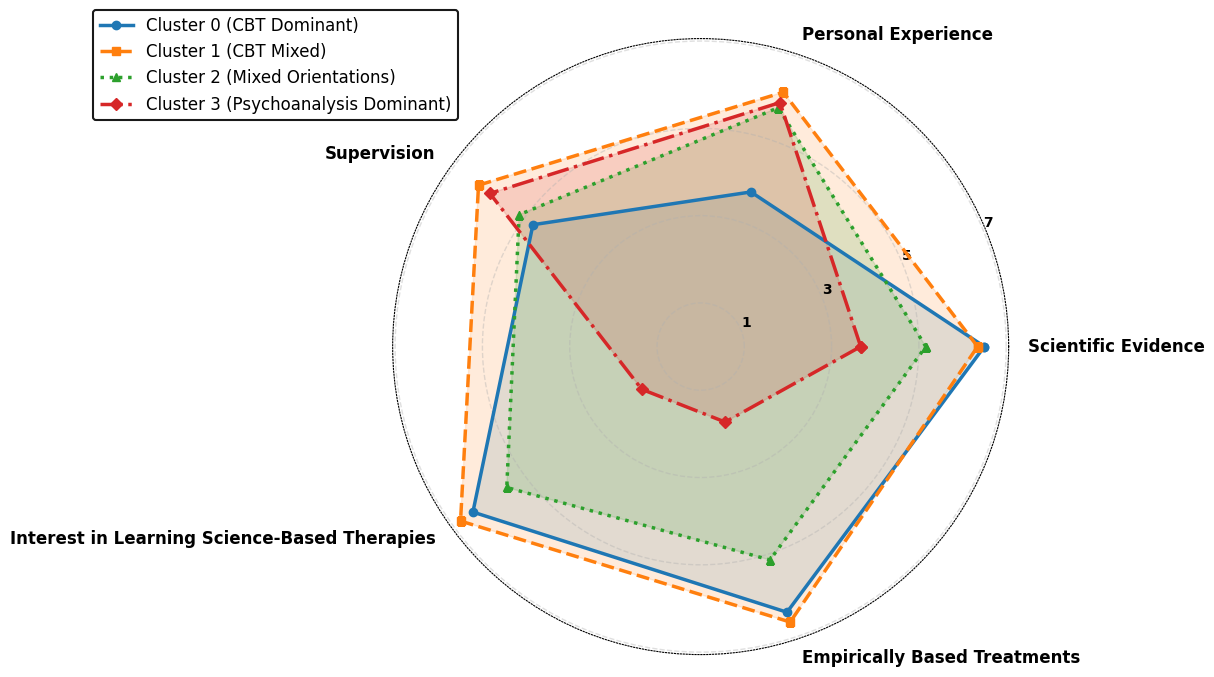

In [17]:
# Define top variables for radar plot with translations
top_variables = {
    "s2_evidencia_cientifica": "Scientific Evidence", 
    "s2_experiencia_personal": "Personal Experience", 
    "s3_supervision": "Supervision", 
    "s4_interes_aprender_tbe": "Interest in Learning Science-Based Therapies", 
    "s4_tratamientos_utilizados_base_empirica": "Empirically Based Treatments"
}

# Reduce the cluster means to the selected top variables
valid_columns = [col for col in top_variables.keys() if col in cluster_means.columns]
actual_means = cluster_means[valid_columns]

# Radar plot setup
angles = np.linspace(0, 2 * np.pi, len(valid_columns), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Cluster labels
cluster_labels_radar_plot = {
    0: "Cluster 0 (CBT Dominant)",
    1: "Cluster 1 (CBT Mixed)",
    2: "Cluster 2 (Mixed Orientations)",
    3: "Cluster 3 (Psychoanalysis Dominant)"
}

# Define a more distinct color palette manually
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red

line_styles = ['solid', 'dashed', 'dotted', 'dashdot']
markers = ['o', 's', '^', 'D']

# Iterate over each cluster and plot with professional styling
for idx, (cluster, color) in enumerate(zip(actual_means.index, custom_colors)):
    values = actual_means.loc[cluster].tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, label=cluster_labels_radar_plot[cluster], linewidth=2.5, linestyle=line_styles[idx], marker=markers[idx], color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

# Improve Axis Labels
ax.set_xticks(angles[:-1])  
ax.set_xticklabels(top_variables.values(), fontsize=12, fontweight='bold')

# Rotate labels for clarity
for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
    angle_deg = np.degrees(angle)
    if 90 < angle_deg < 270:
        label.set_rotation(angle_deg + 180)
        label.set_ha("right")
    else:
        label.set_rotation(angle_deg)
        label.set_ha("left")

# Improve Grid and Borders
ax.yaxis.grid(True, linestyle="dashed", alpha=0.4, linewidth=1)
ax.xaxis.grid(False)  # Remove radial grid for clarity
ax.spines["polar"].set_visible(True)
ax.spines["polar"].set_linestyle("dotted")

# Improve Radial Scale
ax.set_yticks([1, 3, 5, 7])
ax.set_yticklabels(["1", "3", "5", "7"], fontsize=10, fontweight="bold")

# Remove title, replace with caption
fig.suptitle("", fontsize=0)  

# Add legend box
legend = ax.legend(loc="upper left", bbox_to_anchor=(-0.50, 1.06), frameon=True, fontsize=12)
legend.get_frame().set_edgecolor("black")
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)

plt.show()

## 4. ANOVA and Logistic Regression

### 4.1 ANOVA to compare gender, age, and weekly hours across the clusters


--- Descriptive Statistics for Age ---
         count       mean        std   min    25%   50%    75%   max
Cluster                                                             
0         39.0  30.461538   5.399055  24.0  27.00  30.0  33.00  55.0
1         54.0  32.222222   6.823010  21.0  27.25  30.0  35.75  49.0
2         56.0  35.875000   9.657898  23.0  28.00  33.5  41.00  61.0
3         33.0  39.454545  11.130170  27.0  31.00  36.0  44.00  77.0

--- Descriptive Statistics for Patient Hours ---
         count       mean        std  min    25%   50%   75%   max
Cluster                                                           
0         39.0  18.794872  10.679985  3.0  10.00  16.0  26.5  42.0
1         54.0  24.314815  12.709860  2.0  15.75  24.0  30.0  65.0
2         56.0  26.750000  16.790961  0.0  14.00  25.0  38.5  75.0
3         33.0  29.878788  15.396342  3.0  20.00  30.0  40.0  75.0

--- Descriptive Statistics for Gender ---
         count      mean       std  min  25%  50%  

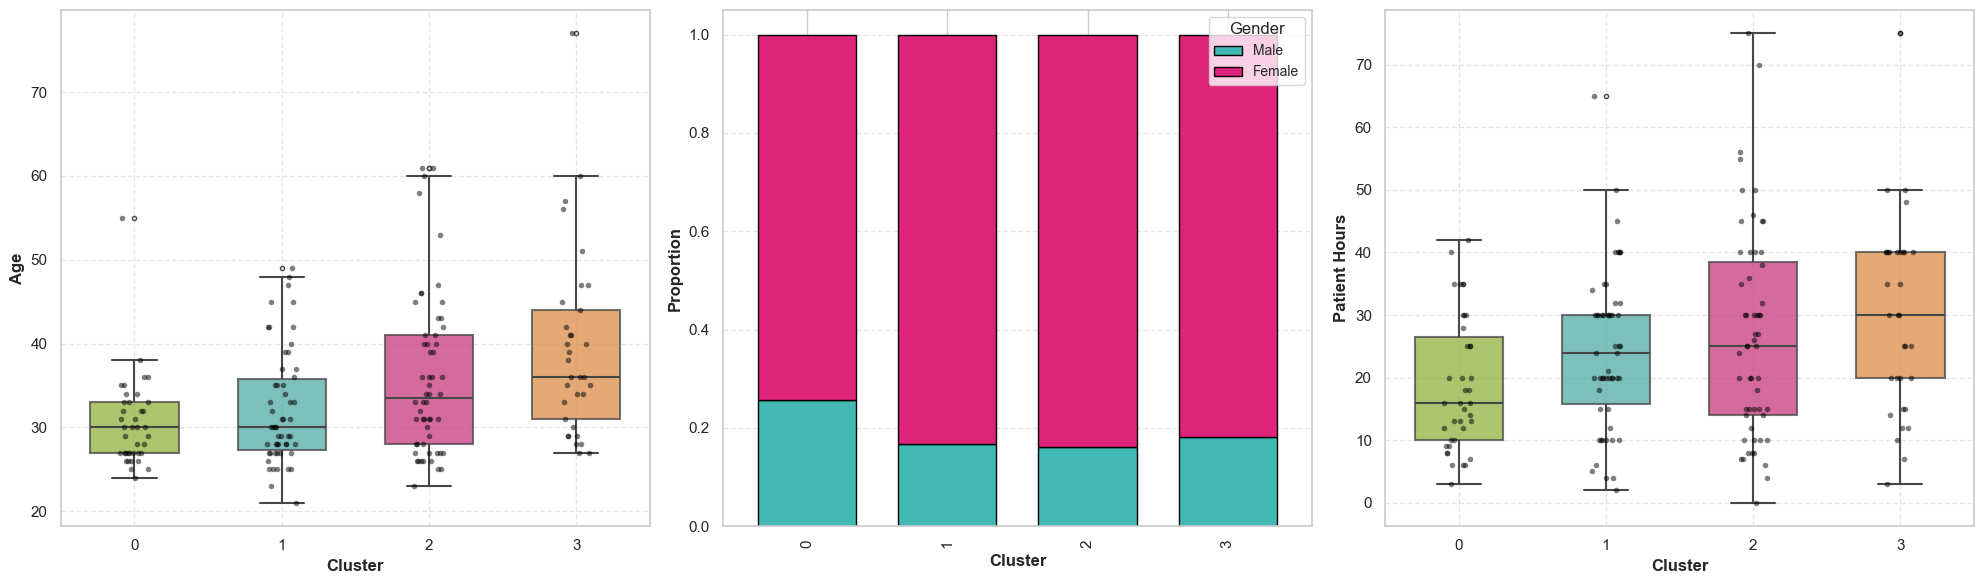

ANOVA for Age: F=8.54, p=0.0000
ANOVA for Patient Hours: F=4.09, p=0.0077
ANOVA for Gender: F=0.54, p=0.6549


In [18]:
# Filter dataset to include only Masculino and Femenino in s1_genero
filtered_data = all_data_clean[all_data_clean['s1_genero'].isin(["Masculino", "Femenino"])].copy()

# Encode gender as binary (Masculino=0, Femenino=1)
filtered_data['s1_genero_encoded'] = filtered_data['s1_genero'].map({"Masculino": 0, "Femenino": 1})

# Descriptive statistics for variables across all clusters
age_stats = filtered_data.groupby('Cluster')['s1_edad'].describe()
hours_stats = filtered_data.groupby('Cluster')['s1_horas_semana_pacientes_atendidos'].describe()
gender_stats = filtered_data.groupby('Cluster')['s1_genero_encoded'].describe()

print("\n--- Descriptive Statistics for Age ---")
print(age_stats)
print("\n--- Descriptive Statistics for Patient Hours ---")
print(hours_stats)
print("\n--- Descriptive Statistics for Gender ---")
print(gender_stats)

sns.set_theme(style="whitegrid")

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns

# ---- 1. Age Distribution ----
sns.boxplot(data=filtered_data, x='Cluster', y='s1_edad',
            hue='Cluster',  # Fix: Explicitly assign hue
            palette=["#9AC529", "#42B9B2", "#DE237B", "#F38A31"],
            width=0.6, linewidth=1.5, fliersize=3, 
            boxprops=dict(alpha=0.75), ax=axes[0], legend=False)  # Disable legend
sns.stripplot(data=filtered_data, x='Cluster', y='s1_edad',
              color="black", alpha=0.5, jitter=True, size=4, ax=axes[0])
#axes[0].set_title('Age Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Age', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=11)
axes[0].grid(True, linestyle='--', alpha=0.5)

# ---- 2. Gender Distribution (Stacked Bar Plot) ----
gender_counts = filtered_data.groupby(['Cluster', 's1_genero_encoded']).size().unstack()
gender_proportions = gender_counts.div(gender_counts.sum(axis=1), axis=0)
gender_proportions.plot(kind='bar', stacked=True, 
                        color=["#42B9B2", "#DE237B"], edgecolor="black", 
                        ax=axes[1], width=0.7)
#axes[1].set_title('Gender Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Proportion', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=11)
axes[1].legend(["Male", "Female"], title="Gender", fontsize=10, title_fontsize=12, frameon=True)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# ---- 3. Patient Hours Distribution ----
sns.boxplot(data=filtered_data, x='Cluster', y='s1_horas_semana_pacientes_atendidos',
            hue='Cluster',  # Fix: Explicitly assign hue
            palette=["#9AC529", "#42B9B2", "#DE237B", "#F38A31"],
            width=0.6, linewidth=1.5, fliersize=3, 
            boxprops=dict(alpha=0.75), ax=axes[2], legend=False)  # Disable legend
sns.stripplot(data=filtered_data, x='Cluster', y='s1_horas_semana_pacientes_atendidos',
              color="black", alpha=0.5, jitter=True, size=4, ax=axes[2])
#axes[2].set_title('Patient Hours Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Patient Hours', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='both', labelsize=11)
axes[2].grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig("multinomial_logistic_regression.png", dpi=300, bbox_inches='tight')

# ANOVA test for differences across clusters
anova_age = f_oneway(
    filtered_data[filtered_data['Cluster'] == 0]['s1_edad'],
    filtered_data[filtered_data['Cluster'] == 1]['s1_edad'],
    filtered_data[filtered_data['Cluster'] == 2]['s1_edad'],
    filtered_data[filtered_data['Cluster'] == 3]['s1_edad']
)
print(f"ANOVA for Age: F={anova_age.statistic:.2f}, p={anova_age.pvalue:.4f}")

anova_hours = f_oneway(
    filtered_data[filtered_data['Cluster'] == 0]['s1_horas_semana_pacientes_atendidos'],
    filtered_data[filtered_data['Cluster'] == 1]['s1_horas_semana_pacientes_atendidos'],
    filtered_data[filtered_data['Cluster'] == 2]['s1_horas_semana_pacientes_atendidos'],
    filtered_data[filtered_data['Cluster'] == 3]['s1_horas_semana_pacientes_atendidos']
)
print(f"ANOVA for Patient Hours: F={anova_hours.statistic:.2f}, p={anova_hours.pvalue:.4f}")

anova_gender = f_oneway(
    filtered_data[filtered_data['Cluster'] == 0]['s1_genero_encoded'],
    filtered_data[filtered_data['Cluster'] == 1]['s1_genero_encoded'],
    filtered_data[filtered_data['Cluster'] == 2]['s1_genero_encoded'],
    filtered_data[filtered_data['Cluster'] == 3]['s1_genero_encoded']
)
print(f"ANOVA for Gender: F={anova_gender.statistic:.2f}, p={anova_gender.pvalue:.4f}")


### 4.2 Logistic Regression

In [19]:
# Filter dataset to include only Masculino and Femenino in s1_genero
filtered_data = all_data_clean[all_data_clean['s1_genero'].isin(["Masculino", "Femenino"])].copy()

# Encode gender as binary (Masculino=0, Femenino=1)
filtered_data['s1_genero_encoded'] = filtered_data['s1_genero'].map({"Masculino": 0, "Femenino": 1})

# Prepare data for multinomial logistic regression
predictors = ['s1_edad', 's1_horas_semana_pacientes_atendidos', 's1_genero_encoded']
X = filtered_data[predictors]
y = filtered_data['Cluster']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept term
X_scaled = sm.add_constant(X_scaled)

# Fit multinomial logistic regression model using statsmodels
log_reg = sm.MNLogit(y, X_scaled)
result = log_reg.fit()

# Print summary of the model
print(result.summary())


Optimization terminated successfully.
         Current function value: 1.266043
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                Cluster   No. Observations:                  182
Model:                        MNLogit   Df Residuals:                      170
Method:                           MLE   Df Model:                            9
Date:                Wed, 16 Apr 2025   Pseudo R-squ.:                 0.07104
Time:                        10:25:34   Log-Likelihood:                -230.42
converged:                       True   LL-Null:                       -248.04
Covariance Type:            nonrobust   LLR p-value:                 5.400e-05
 Cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5755      0.256      2.251      0.024       0.074       1.077
x1             0.3823      0.

## 5. Visualizations

### 5.1 Clusters in PCA Space

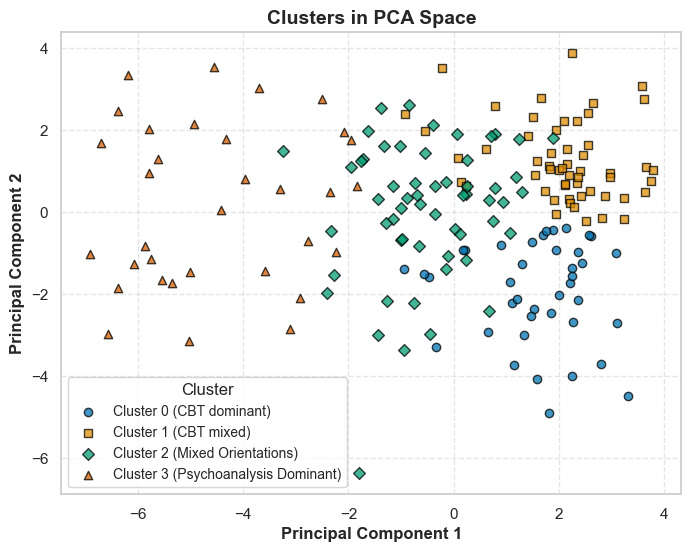

In [20]:
# Ensure cluster labels are in the dataset
all_data_clean = all_data_clean.copy()
all_data_clean['Cluster'] = cluster_labels

# Define colorblind-friendly palette and distinct markers
palette = sns.color_palette("colorblind", len(np.unique(cluster_labels)))
markers = ['o', 's', 'D', '^']  

# Define custom cluster labels
cluster_labels_map = {
    0: "Cluster 0 (CBT dominant)",
    1: "Cluster 1 (CBT mixed)",
    2: "Cluster 2 (Mixed Orientations)",
    3: "Cluster 3 (Psychoanalysis Dominant)"
}

# Create figure
plt.figure(figsize=(8, 6))

# Loop through clusters and plot with different markers
for i, cluster in enumerate(np.unique(cluster_labels)):
    plt.scatter(pca_reduced_data[cluster_labels == cluster, 0], 
                pca_reduced_data[cluster_labels == cluster, 1], 
                label=cluster_labels_map.get(cluster, f'Cluster {cluster}'),  # Use the mapping
                color=palette[i], 
                marker=markers[i % len(markers)],  # Assign markers cyclically
                alpha=0.75, edgecolor='black')

# Formatting improvements
plt.title('Clusters in PCA Space', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12, fontweight='bold')
plt.ylabel('Principal Component 2', fontsize=12, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)  # Add subtle grid for better readability

# Improve legend
plt.legend(title="Cluster", fontsize=10, title_fontsize=12, frameon=True, loc='best')

plt.show()

### 5.2 Heatmap For Clusters

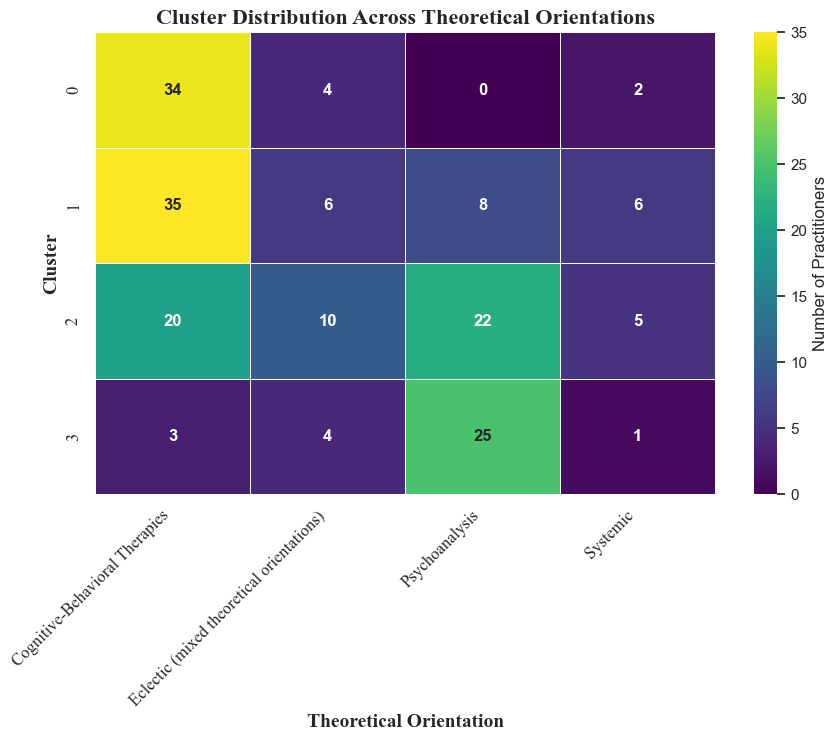

In [21]:
# Define translation dictionary for theoretical orientations
orientation_translation = {
    'Terapias Cognitivas/Comportamentales': 'Cognitive-Behavioral Therapies',
    'Psicoanálisis': 'Psychoanalysis',
    'Ecléctico (más de una de estas opciones)': 'Eclectic (mixed theoretical orientations)',
    'Sistémica': 'Systemic'
}

# Apply translation to the orientation column
all_data_clean = all_data_clean.copy()
all_data_clean['s1_orientacion_teo'] = all_data_clean['s1_orientacion_teo'].replace(orientation_translation)

# Generate Cluster Distribution Heatmap
cluster_distribution = pd.crosstab(all_data_clean['Cluster'], all_data_clean['s1_orientacion_teo'])

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap with colorblind-friendly "viridis" colormap
sns.heatmap(cluster_distribution, 
            annot=True, fmt='d', cmap='viridis', linewidths=0.5, 
            linecolor='white', cbar_kws={'label': 'Number of Practitioners'}, 
            annot_kws={"fontsize": 12, "fontweight": "bold"})

# Formatting
plt.title('Cluster Distribution Across Theoretical Orientations', fontsize=16, fontweight='bold', fontname='Times New Roman')
plt.xlabel('Theoretical Orientation', fontsize=14, fontweight='bold', fontname='Times New Roman')
plt.ylabel('Cluster', fontsize=14, fontweight='bold', fontname='Times New Roman')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Show plot
plt.show()